# Introduction



# Part 1) Pre-processing and Dataset Visualization

To start, we will pre-process the dataset, removing unnecessary textual elements and formatting it to the input the classifiers understand, as visualize its characteristics such as data distribution, word-count and others.

First, we load the dataset onto a Pandas DataFrame, drop an unneeded column and change a string label to numeric:

In [1]:
import pandas as pd

df = pd.read_csv('../data/proc/comments_lang.csv')

df = df.drop(columns='classe 1')
df.columns=['comment', 'rating', 'rating_b']
df["rating_b"] = df["rating_b"].replace({'nao excelente': 0, 'excelente': 1})
df.head()

,comment,rating,rating_b
0,Good life animation Really smooth animation w...,3,0
1,Terrific Demo Applet This is a really great ap...,5,1
2,Generates Fractal coastlines and allows measur...,5,1
3,Great example of actual use in a High School T...,5,1
4,Excellent demonstration of Bragg's Law I reall...,4,0


Before we can present information about the textual data, we must do a cleanup. This will involve:
- Lowercasing of words,
- Removal of hyperlinks,
- Removal of punctuation (except groups of exclamation and interrogation marks, as they might be semantically relevant) and
- Filtering non-english examples.


In [2]:
# https://pypi.org/project/langdetect/
# from langdetect import detect
# for i in range(len(df)):
#     if(detect(df['comment'][i]) != 'en'):
#         print(i, ': ', detect(df['comment'][i]), '( ', df['comment'][i], ' )')

The language filtering performed served as basis for manual removal on the source file, as there were very few non-english entries.

After the language filtering, we perform lowercasing and removal of hyperlinks and punctuation.

In [3]:
df['comment'] = df['comment'].str.lower()

# df['comment'] = df['comment'].str.replace(r'http\S+\b', '')

# from string import punctuation

# def remove_punctuations(text):
#     for punct in punctuation.replace('?', '').replace('!', ''):
#         text = text.replace(punct, ' ')
#     return text

# df['comment'] = df['comment'].apply(remove_punctuations)
# df.head()


Then, we plot the histogram of categories in the dataset:


[Text(0,0.5,'Percentual'), Text(0.5,0,'Rating')]

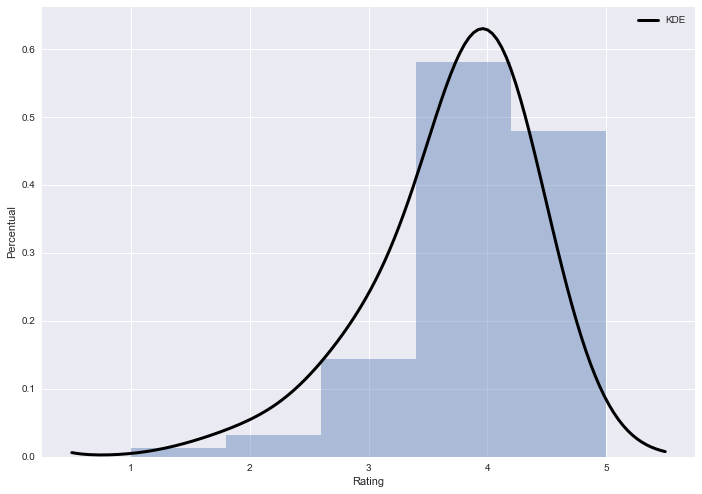

In [4]:
%matplotlib inline
import seaborn as sns, numpy as np
sns.set();
sns.set(rc={'figure.figsize':(11.7,8.27)})
x = df['rating']
from scipy.stats import norm

ax = sns.distplot(x,kde_kws={"color": "k", "lw": 3, 'bw': .5, 'clip': (1,5), "label": "KDE"}, bins=5)
ax.set(xlabel='Rating', ylabel='Percentual')



We can see that from the ratings 1 through 5, the data is considerably imbalanced towards the higher (more positive values).
By transforming the multiclass dataset to a binary, Non-Excelent/Excelent dataset, in which ratings 1-4 form the Non-Excellent and 5 forms the Excellent category, we achieve the following distribution:

[Text(0,0.5,'Comments'), Text(0.5,0,'Rating')]

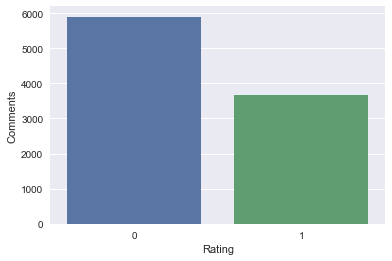

In [5]:
x_2 = df['rating_b']
ax_2 = sns.countplot(x_2)
ax_2.set(xlabel='Rating', ylabel='Comments')

We can see from the graph that with the binary distribution, the Non-Excellent class has around 6000 examples, while class Excellent amounts to a little below 4000, which allows for a more balanced training.

Next, we present the average word count for the 5-category dataset, as well as the binary one. We also consider average word counts if filtering of stop words is used:

In [6]:
from sklearn.feature_extraction import text
stop = text.ENGLISH_STOP_WORDS
# If not donwloaded, uncomment this!
# import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stop.union(stopwords.words('english'))

# https://pypi.org/project/stop-words/
from stop_words import get_stop_words
stop = stop.union(get_stop_words('en'))

df['comment_stop'] = df['comment'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

# from string import punctuation

# def remove_punctuations(text):
#     for punct in punctuation.replace('?', '').replace('!', ''):
#         text = text.replace(punct, ' ')
#     return text

# df['comment_stop'] = df['comment_stop'].apply(remove_punctuations)
####


df['count'] = df['comment'].str.split().str.len()
df['count_stop'] = df['comment_stop'].str.split().str.len()



word_count_5_cat = pd.DataFrame(columns = ['Rating', 'Average (with stop-words)', 'Average (without stop-words)'])
word_count_2_cat = pd.DataFrame(columns = ['Class', 'Average (with stop-words)', 'Average (without stop-words)'])

for i in range(1, 6):
    word_count_5_cat.loc[i] = [i,
                               int(df[df['rating'] == i]['count'].mean()),
                               int(df[df['rating'] == i]['count_stop'].mean())]

for i in range(2):
    word_count_2_cat.loc[i] = ['Non-Excellent' if i == 0 else 'Excellent',
                               int(df[df['rating_b'] == i]['count'].mean()),
                               int(df[df['rating_b'] == i]['count_stop'].mean())]

display(word_count_5_cat)
display(word_count_2_cat)

,Rating,Average (with stop-words),Average (without stop-words)
1,1,42,19
2,2,64,30
3,3,70,33
4,4,75,36
5,5,70,34


,Class,Average (with stop-words),Average (without stop-words)
0,Non-Excellent,73,35
1,Excellent,70,34


As can be seen, the removal of stop-words reduces to around half average word count for the examples, both for 5 categories and binary. We will experiment with both in the Classification phase to determine whether this translates to better results.

## Part 1.5) Over-sampling
After the rest of the classification workflow is done, we may come back to over-sample the training data and check whether it impacts the classifiers positively.

https://beckernick.github.io/oversampling-modeling/
https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets
https://imbalanced-learn.org/en/stable/over_sampling.html

# Part 2) Classification

To start, we separate the data into training set and test set, so that the feature extraction is done separately. That way, the model can only learn vocabulary on the training set, mimicking the real life application of out-of-sample data.

In [34]:
from sklearn.model_selection import train_test_split

docs_train, docs_test, y_train, y_test = train_test_split(
    df['comment'], df['rating_b'], test_size=0.25)

Workflow question: Do we get less total features in our vectorized representation? Experiment with two settings:
- Regular comments before removing stop-words (column 'comment) vectorized with the flag 'stop-words';
- Comments post stop-word removal, without the flag stop-words;

In [35]:
from sklearn.feature_extraction.text import CountVectorizer


count_vec = CountVectorizer()
tf_vec = TfidfVectorizer()


X_train = count_vec.fit_transform(docs_train)

First, we classify using all default settings, so that we can get a good baseline view of the classifiers:

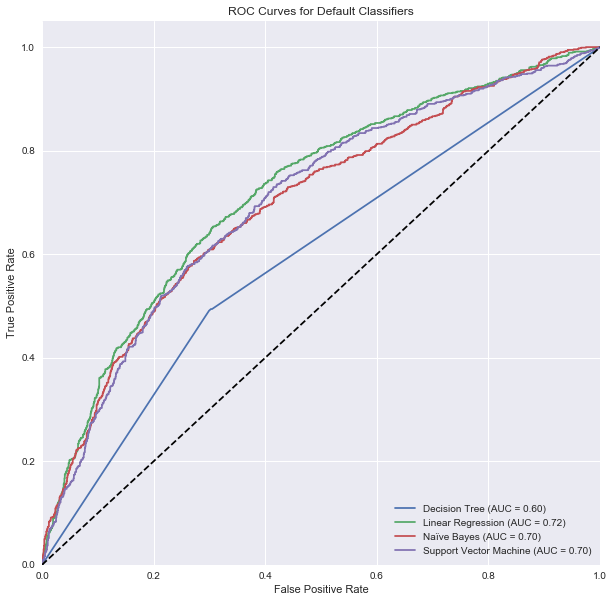

In [56]:
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV


classifiers={
    'Decision Tree': DecisionTreeClassifier(),
    'Linear Regression': LogisticRegression(),
    'Naïve Bayes': MultinomialNB(),
    'Support Vector Machine': CalibratedClassifierCV(LinearSVC())
}

X_test = count_vec.transform(docs_test)

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for key, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)[:,1]
    roc_score = roc_auc_score(y_test, y_pred_proba)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label='{0} (AUC = {1:.2f})'.format(key,roc_score))

plt.plot([0,1],[0,1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Default Classifiers')
plt.legend(loc='lower right')
plt.show()
#performing predictions


We can see that, while 0.72 is an above average  result, we must investigage whether the fine-tuning of parameters can lead to better results, or the dataset reaches its potential for these classifiers at this baseline.

Next, we use TF-IDF to try to improve our results:

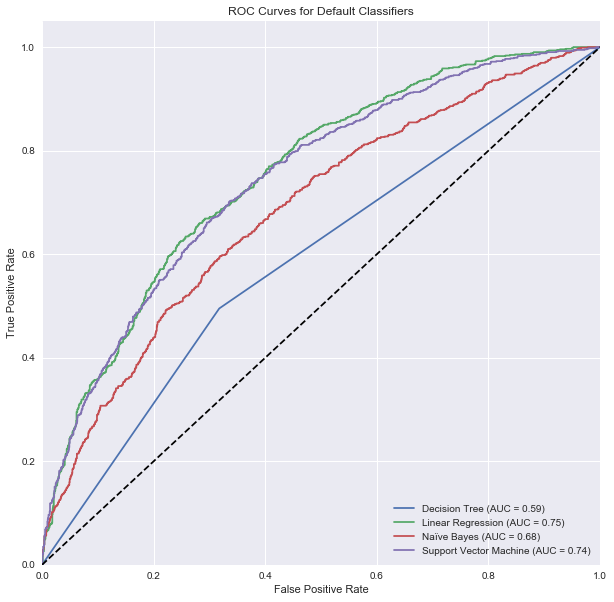

In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_vec = TfidfVectorizer()

X_train = tf_vec.fit_transform(docs_train)
X_test = tf_vec.transform(docs_test)
plt.figure(figsize=(10, 10))
for key, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)[:,1]
    roc_score = roc_auc_score(y_test, y_pred_proba)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label='{0} (AUC = {1:.2f})'.format(key,roc_score))
    
plt.plot([0,1],[0,1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Default Classifiers')
plt.legend(loc='lower right')
plt.show()


We can see a slight improvement from the previous results, which makes us presume that further fine-tuning may provide even better results.
That being said, we must investigate this in a more streamlined way, so that we don't take forever investigating each parameter at a time. For that, we will use Scikit-learn's GridSearchCV, which optimizes the hyperparameters from both the vectorizers and classifiers. We will investigate one classifier at a time for its parameters, then choose the best out of all classifiers and plot them together for comparison.

We'll start with the Decision Tree:

In [68]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

parameters = {
    'vec__max_df': (0.5, 0.75, 1.0),  
#     'vec__max_features': (None, 5000, 10000),  
    'vec__min_df': (1, 5, 10, 20, 50),
#     'vec__binary': (True, False), 
    'tfidf__use_idf': (True, False),  
    'tfidf__sublinear_tf': (True, False),  
    'tfidf__norm': ('l1', 'l2'),
    'clf__max_depth': np.arange(3, 10)  
}

pipeline = Pipeline([
    ('vec',   CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf',   DecisionTreeClassifier())
])

if __name__ == "__main__":
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=10)
    grid_search.fit(docs_train, y_train)
    
    n_candidates = len(grid_search.cv_results_['params'])
    for i in range(n_candidates):
        print(i, 'params - %s; mean - %0.2f; std - %0.2f'
                 % (grid_search.cv_results_['params'][i],
                    grid_search.cv_results_['mean_test_score'][i],
                    grid_search.cv_results_['std_test_score'][i]))

    y_predicted = grid_search.predict(docs_test)

    print(metrics.classification_report(y_test, y_predicted))

    cm = metrics.confusion_matrix(y_test, y_predicted)
    print(cm)


    print(grid_search.best_score_)

    for param_name in sorted(parameters.keys()):
        print("%s: %r" % (param_name, grid_search.best_params_[param_name]))
    

Fitting 3 folds for each of 840 candidates, totalling 2520 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   50.0s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   57.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.3min
[Paralle

0 params - {'clf__max_depth': 3, 'tfidf__norm': 'l1', 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True, 'vec__max_df': 0.5, 'vec__min_df': 1}; mean - 0.64; std - 0.00
1 params - {'clf__max_depth': 3, 'tfidf__norm': 'l1', 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True, 'vec__max_df': 0.5, 'vec__min_df': 5}; mean - 0.64; std - 0.00
2 params - {'clf__max_depth': 3, 'tfidf__norm': 'l1', 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True, 'vec__max_df': 0.5, 'vec__min_df': 10}; mean - 0.64; std - 0.00
3 params - {'clf__max_depth': 3, 'tfidf__norm': 'l1', 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True, 'vec__max_df': 0.5, 'vec__min_df': 20}; mean - 0.64; std - 0.00
4 params - {'clf__max_depth': 3, 'tfidf__norm': 'l1', 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True, 'vec__max_df': 0.5, 'vec__min_df': 50}; mean - 0.64; std - 0.00
5 params - {'clf__max_depth': 3, 'tfidf__norm': 'l1', 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True, 'vec__max_df': 0.75, 'vec__min_df': 1}; 

NameError: name 'metrics' is not defined